In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import numpy.linalg as alg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# - read data from http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
df_returns = pd.read_csv("12_Industry_Portfolios.csv", skiprows=11, nrows=1057)

df_returns.head()

,Unnamed: 0,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,192607,1.45,15.55,3.67,-1.18,8.01,3.16,0.83,7.04,0.11,1.77,0.37,2.24
1,192608,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.46,4.37
2,192609,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.23,0.35
3,192610,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.16,-2.76
4,192611,5.21,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.24,2.10


In [3]:
# - convert into a time series object

df_returns.rename(columns = {"Unnamed: 0":"Date"}, inplace = True)
df_returns.set_index("Date", inplace = True)

In [4]:
# - now calculate the holdings vector at each point in time, weighted based on the previous 12 months' data

T = df_returns.shape[0]
H = np.array([[0] * 12] * 13)
A = np.matrix([1] * 12)
A_t = np.transpose(A)

for t in range(14, T+1):
    
    R = df_returns.iloc[(t-13):(t-1)]
    
    # - get mean of each industry
    alpha = np.matrix(R.mean())
    alpha_t = np.transpose(alpha)
    
    # - annualise covariance matrix and invert
    V = 12 * np.matrix(df.cov(R))
    V_inv = alg.pinv(V)
    
    # - compute holdings vector, scale with risk constraints
    h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
    h_t = np.transpose(h)
    h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
    h = np.transpose(h)
    
    H = np.append(H, h, axis=0)

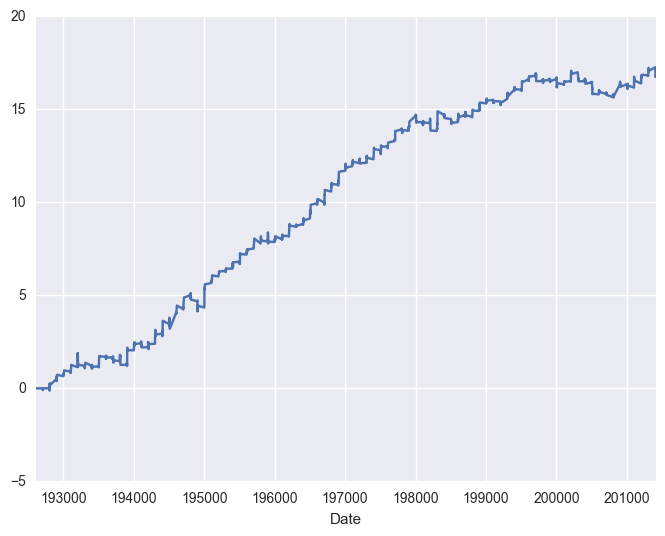

In [5]:
backtest_returns = H*df_returns
backtest_returns_cumulative = backtest_returns.sum(1).cumsum()
backtest_returns_cumulative.plot(figsize=(8, 6))

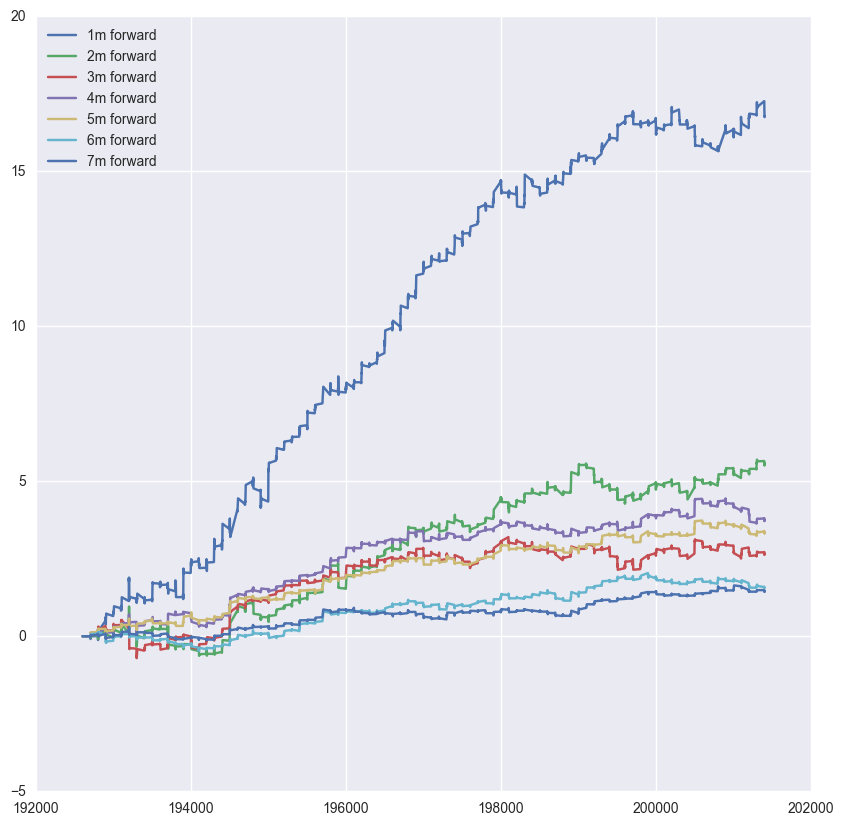

In [6]:
# - how long does this signal last? its performance appears to drop significantly beyond 1 month
    
months_forward = range(1,8)
plt.figure(figsize=(10, 10))

for m in months_forward:

    T = df_returns.shape[0]
    
    H = np.array([[0] * 12] * 13)

    for t in range(14, T+1):

        R = df_returns.iloc[(t-13):(t-m)]
        alpha = np.matrix(R.mean())
        alpha_t = np.transpose(alpha)
        V = 12 * np.matrix(df.cov(R))
        V_inv = alg.pinv(V)

        h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
        h_t = np.transpose(h)
        h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))

        h = np.transpose(h)

        H = np.append(H, h, axis=0)

    backtest_returns_new = H*df_returns
    backtest_returns_new_cumulative = backtest_returns_new.sum(1).cumsum()
    plt.plot(backtest_returns_new_cumulative, label=str(m) + "m forward")
    plt.legend(loc="upper left")


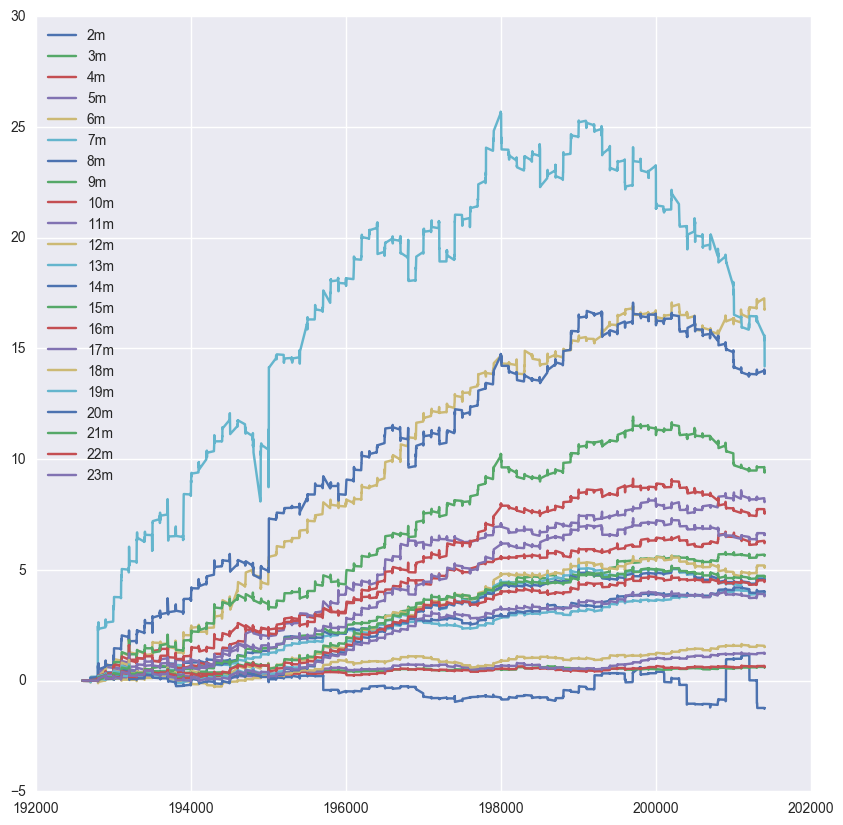

In [7]:
# - and how far back should the data be colleted to optimise this strategy? looks like 13 months is the winner (by quite 
#   a margin - why is this the case?)
    
months_lookback = range(2, 24)
plt.figure(figsize=(10, 10))

for m in months_lookback:

    T = df_returns.shape[0]
    
    H = np.array([[0] * 12] * (m+1))

    for t in range(m+2, T+1):

        R = df_returns.iloc[(t-(m+1)):(t-1)]
        alpha = np.matrix(R.mean())
        alpha_t = np.transpose(alpha)
        V = 12 * np.matrix(df.cov(R))
        V_inv = alg.pinv(V)

        h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
        h_t = np.transpose(h)
        h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))

        h = np.transpose(h)

        H = np.append(H, h, axis=0)

    backtest_returns_new = H*df_returns
    backtest_returns_new_cumulative = backtest_returns_new.sum(1).cumsum()
    plt.plot(backtest_returns_new_cumulative, label=str(m) + "m")
    plt.legend(loc="upper left")